Original dataset shape: (284807, 31)
Class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

=== Undersampling Techniques ===

Applying random undersampling...

Resampled dataset shape (random undersampling): (984, 30)
Resampled class distribution:
 Class
0    492
1    492
Name: count, dtype: int64


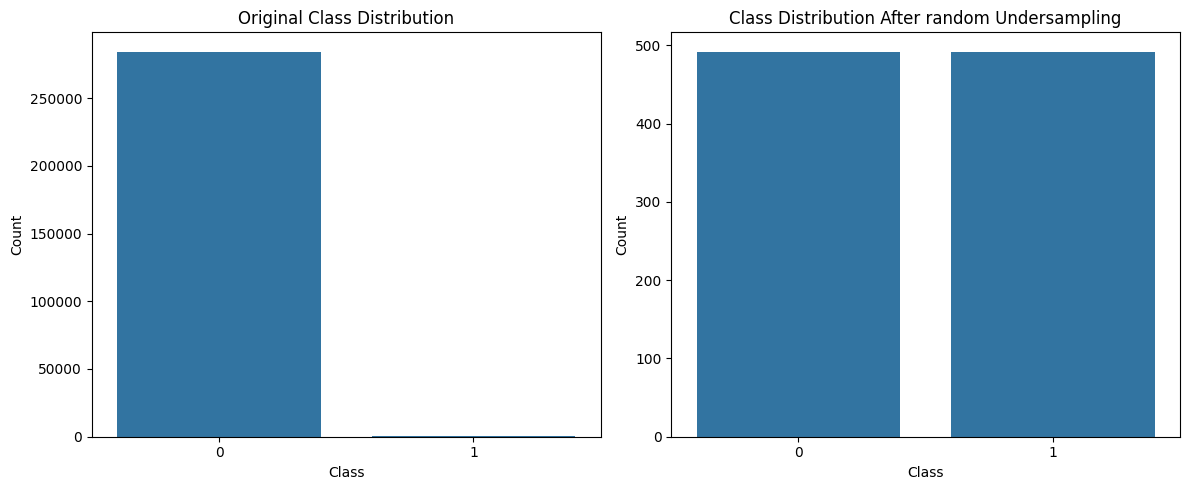


=== Dimensionality Reduction ===

Explained variance ratio (PCA): [0.63540198 0.09403849]
Total explained variance: 0.73


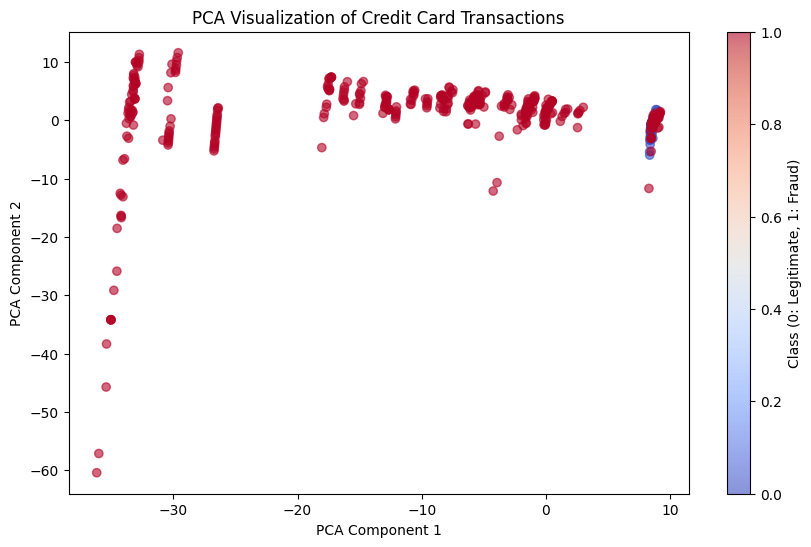

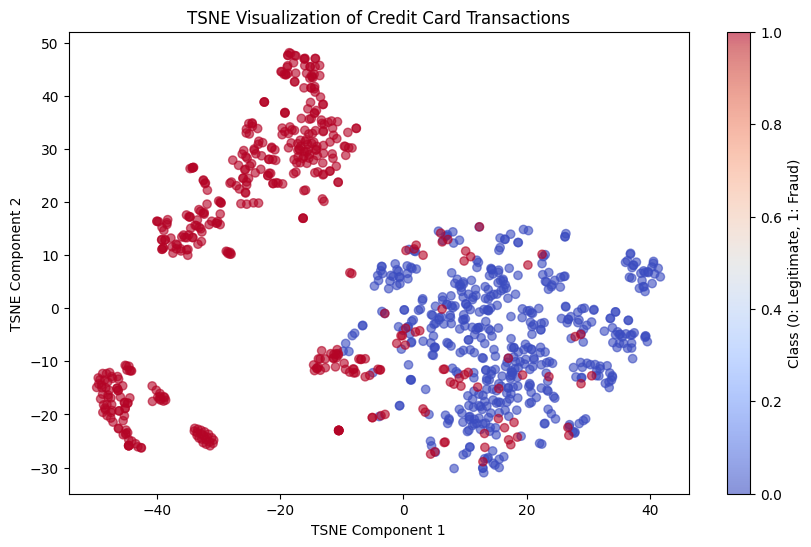


Explained variance ratio (SVD): [0.6333138 0.0946702]
Total explained variance: 0.73


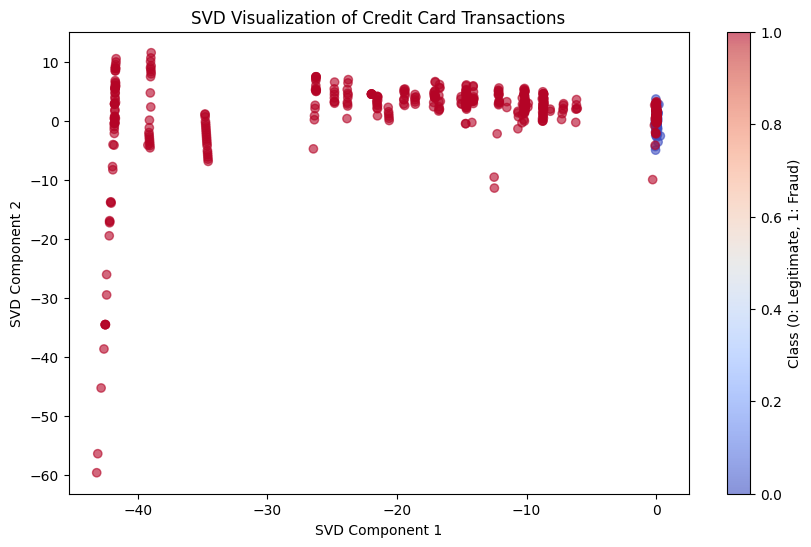


=== Model Training ===

Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       150
           1       0.96      0.90      0.93       146

    accuracy                           0.93       296
   macro avg       0.93      0.93      0.93       296
weighted avg       0.93      0.93      0.93       296

Evaluation Metrics:
- Mean Directional Accuracy (MDA): 0.9324
- Mean Bias Error (MBE): -0.0270
- Root Mean Squared Error (RMSE): 0.2599
- Relative Root Mean Squared Error (RRMSE): 0.2599
- Accuracy: 0.9324

=== Fraud Prevention Simulation ===

Transaction Details: [ 0.         -1.35980713 -0.07278117  2.53634674  1.37815522]...
Fraud Prediction: Legitimate
Probability: Legitimate=0.8330, Fraudulent=0.1670

Transaction Details: [406.          -2.31222654   1.95199201  -1.60985073   3.99790559]...
Fraud Prediction: Fraudulent
Probability: Legitimate=0.0000, Fraudulent=1.0000

=== Fraud Prevention Process

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
import warnings
warnings.filterwarnings('ignore')

class CCFDP:
    def __init__(self):
        self.model = None
        self.scaler = StandardScaler()
        self.rus = RandomUnderSampler(random_state=42)

    def load_data(self, filepath):
        """Load and preprocess the credit card transaction data"""
        self.data = pd.read_csv(filepath)
        print("Original dataset shape:", self.data.shape)
        print("Class distribution:\n", self.data['Class'].value_counts())

        # Separate features and target
        self.X = self.data.drop('Class', axis=1)
        self.y = self.data['Class']

        # Scale the features
        self.X_scaled = self.scaler.fit_transform(self.X)

    def balance_dataset(self, method='random', sampling_strategy='auto'):
        """
        Apply undersampling to balance the dataset
        Available methods:
        - 'random': RandomUnderSampler (default)
        - 'nearmiss': NearMiss (version 1)
        - 'tomek': TomekLinks
        - 'cluster': ClusterCentroids
        """
        if method == 'random':
            sampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
        elif method == 'nearmiss':
            sampler = NearMiss(version=1, sampling_strategy=sampling_strategy)
        elif method == 'tomek':
            sampler = TomekLinks(sampling_strategy=sampling_strategy)
        elif method == 'cluster':
            sampler = ClusterCentroids(sampling_strategy=sampling_strategy, random_state=42)
        else:
            raise ValueError("Invalid undersampling method. Choose from 'random', 'nearmiss', 'tomek', or 'cluster'")

        self.X_resampled, self.y_resampled = sampler.fit_resample(self.X_scaled, self.y)

        print(f"\nResampled dataset shape ({method} undersampling):", self.X_resampled.shape)
        print("Resampled class distribution:\n", pd.Series(self.y_resampled).value_counts())

        # Visualize the class distribution before and after undersampling
        self.plot_class_distribution(method)

    def plot_class_distribution(self, method):
        """Plot class distribution before and after undersampling"""
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.countplot(x=self.y)
        plt.title('Original Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')

        plt.subplot(1, 2, 2)
        sns.countplot(x=self.y_resampled)
        plt.title(f'Class Distribution After {method} Undersampling')
        plt.xlabel('Class')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

    def reduce_dimensions(self, method='pca', n_components=2):
        """Apply dimensionality reduction (PCA, t-SNE, or SVD)"""
        if method == 'pca':
            reducer = PCA(n_components=n_components, random_state=42)
            reduced_data = reducer.fit_transform(self.X_resampled)
            print(f"\nExplained variance ratio (PCA): {reducer.explained_variance_ratio_}")
            print(f"Total explained variance: {sum(reducer.explained_variance_ratio_):.2f}")

        elif method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=42)
            reduced_data = reducer.fit_transform(self.X_resampled)

        elif method == 'svd':
            reducer = TruncatedSVD(n_components=n_components, random_state=42)
            reduced_data = reducer.fit_transform(self.X_resampled)
            print(f"\nExplained variance ratio (SVD): {reducer.explained_variance_ratio_}")
            print(f"Total explained variance: {sum(reducer.explained_variance_ratio_):.2f}")

        else:
            raise ValueError("Invalid method. Choose from 'pca', 'tsne', or 'svd'")

        return reduced_data

    def calculate_metrics(self, y_true, y_pred, y_prob):
        """Calculate various evaluation metrics"""
        # Mean Directional Accuracy (MDA) - for classification, it's similar to accuracy
        mda = accuracy_score(y_true, y_pred)

        # Mean Bias Error (MBE) - difference between mean predictions and mean observations
        mbe = np.mean(y_pred - y_true)

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Relative Root Mean Squared Error (RRMSE)
        rrmse = rmse / (np.max(y_true) - np.min(y_true))

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)

        return {
            'MDA': mda,
            'MBE': mbe,
            'RMSE': rmse,
            'RRMSE': rrmse,
            'Accuracy': accuracy
        }

    def train_model(self):
        """Train the fraud detection model using Logistic Regression"""
        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_resampled, self.y_resampled, test_size=0.3, random_state=42
        )

        # Initialize and train Logistic Regression model
        self.model = LogisticRegression(max_iter=1000, random_state=42)
        self.model.fit(X_train, y_train)

        # Evaluate on test set
        y_pred = self.model.predict(X_test)
        y_prob = self.model.predict_proba(X_test)[:, 1]  # Probability of positive class

        # Calculate metrics
        metrics = self.calculate_metrics(y_test, y_pred, y_prob)

        print("\nLogistic Regression Model Performance:")
        print(classification_report(y_test, y_pred))
        print("Evaluation Metrics:")
        print(f"- Mean Directional Accuracy (MDA): {metrics['MDA']:.4f}")
        print(f"- Mean Bias Error (MBE): {metrics['MBE']:.4f}")
        print(f"- Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
        print(f"- Relative Root Mean Squared Error (RRMSE): {metrics['RRMSE']:.4f}")
        print(f"- Accuracy: {metrics['Accuracy']:.4f}")

    def fraud_prevention(self, transaction_data):
        """Simulate the fraud prevention process"""
        # Scale the transaction data
        transaction_scaled = self.scaler.transform([transaction_data])

        # Predict if the transaction is fraudulent
        prediction = self.model.predict(transaction_scaled)
        proba = self.model.predict_proba(transaction_scaled)

        print(f"\nTransaction Details: {transaction_data[:5]}...")
        print(f"Fraud Prediction: {'Fraudulent' if prediction[0] else 'Legitimate'}")
        print(f"Probability: Legitimate={proba[0][0]:.4f}, Fraudulent={proba[0][1]:.4f}")

        if prediction[0] == 1:  # If fraud detected
            print("\n=== Fraud Prevention Process ===")
            print("1. Sending verification code to registered phone...")
            # Simulate user verification (in real system, would wait for user input)
            verification_code = "123456"  # This would be randomly generated
            user_input = "123456"  # Simulate correct user input

            if user_input == verification_code:
                print("Verification successful. Transaction approved.")
            else:
                print("Verification failed. Sending security question...")
                # Simulate security question (in real system, would be predefined)
                security_answer = "blue"  # Correct answer
                user_answer = "blue"  # Simulate correct user input

                if user_answer == security_answer:
                    print("Security question answered correctly. Transaction approved.")
                else:
                    print("Security question failed. Transaction blocked and card frozen.")

        return prediction[0], proba[0]

    def visualize_results(self, reduced_data, method_name):
        """Visualize the dimensionality reduction results"""
        plt.figure(figsize=(10, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1],
                   c=self.y_resampled, cmap='coolwarm', alpha=0.6)
        plt.title(f'{method_name.upper()} Visualization of Credit Card Transactions')
        plt.xlabel(f'{method_name.upper()} Component 1')
        plt.ylabel(f'{method_name.upper()} Component 2')
        plt.colorbar(label='Class (0: Legitimate, 1: Fraud)')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Initialize the CCFDP system
    fraud_detector = CCFDP()

    # Load the dataset (replace with your actual file path)
    fraud_detector.load_data('creditcard.csv')

    # Balance the dataset using different undersampling techniques
    print("\n=== Undersampling Techniques ===")
    for method in ['random', 'nearmiss', 'tomek', 'cluster']:
        try:
            print(f"\nApplying {method} undersampling...")
            fraud_detector.balance_dataset(method=method)

            # For demonstration, we'll just use the first undersampling method for the rest
            if method == 'random':
                break

        except Exception as e:
            print(f"Error with {method} undersampling: {str(e)}")
            continue

    # Apply dimensionality reduction techniques
    print("\n=== Dimensionality Reduction ===")

    # PCA
    pca_data = fraud_detector.reduce_dimensions(method='pca', n_components=2)
    fraud_detector.visualize_results(pca_data, 'pca')

    # t-SNE (Note: t-SNE can be slow on large datasets)
    tsne_data = fraud_detector.reduce_dimensions(method='tsne', n_components=2)
    fraud_detector.visualize_results(tsne_data, 'tsne')

    # SVD
    svd_data = fraud_detector.reduce_dimensions(method='svd', n_components=2)
    fraud_detector.visualize_results(svd_data, 'svd')

    # Train the model (Logistic Regression)
    print("\n=== Model Training ===")
    fraud_detector.train_model()

    # Simulate fraud prevention with a test transaction
    print("\n=== Fraud Prevention Simulation ===")
    # Create a test transaction (in practice, this would come from real-time data)
    # Let's use the first legitimate transaction from the original dataset as an example
    legit_sample = fraud_detector.X[fraud_detector.y == 0].iloc[0].values
    fraud_detector.fraud_prevention(legit_sample)

    # Now test with a fraudulent transaction (if available in dataset)
    if 1 in fraud_detector.y.values:
        fraud_sample = fraud_detector.X[fraud_detector.y == 1].iloc[0].values
        fraud_detector.fraud_prevention(fraud_sample)